In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.metrics import r2_score , mean_squared_error , mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV 
from sklearn.preprocessing import MinMaxScaler

In [215]:
df = pd.read_excel("premiums_young_with_gr.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4


In [216]:
df.shape

(20096, 14)

## 1). Data Cleaning & EDA

In [217]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount', 'Genetical_Risk'],
      dtype='object')

In [218]:
df.columns = df.columns.str.replace(' ' , '_').str.lower()

In [219]:
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4


### Handle NA Values

In [220]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [221]:
df.dropna(inplace = True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [222]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

### Handle Outliers

In [223]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [224]:
df[df.number_of_dependants < 0].shape

(22, 14)

In [225]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([-3, -1], dtype=int64)

In [226]:
# 'number_of_dependants' column contain -3 and -1 values for 72 rows

In [227]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

In [228]:
numeric_columns = df.select_dtypes(['float64' , 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

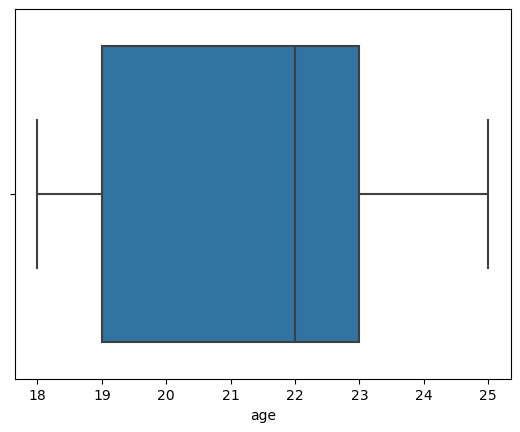

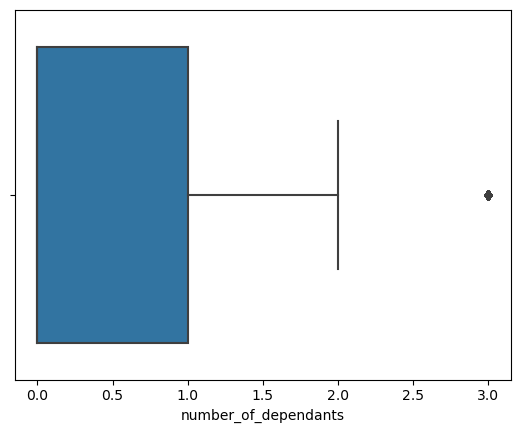

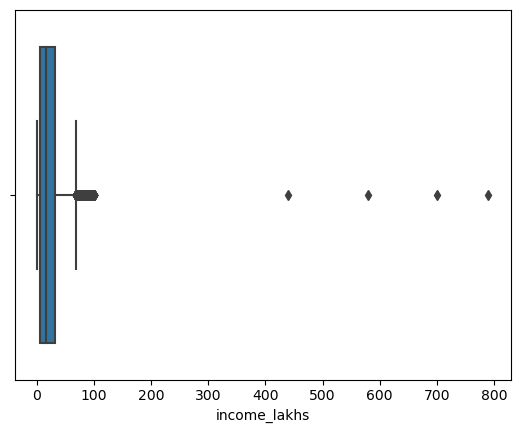

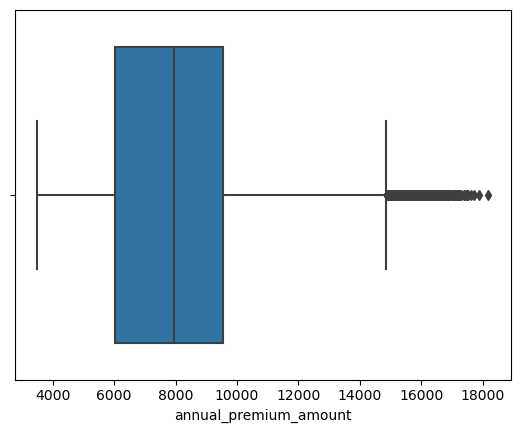

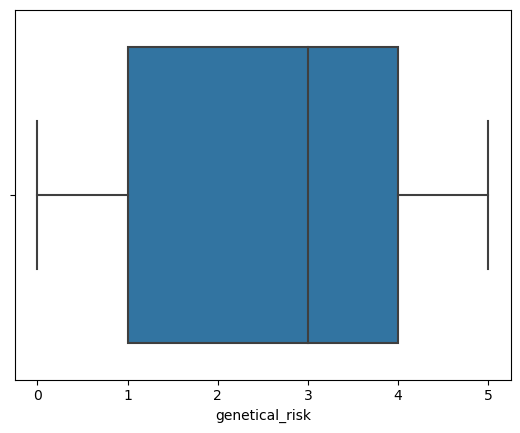

In [229]:
for col in numeric_columns:
    sns.boxplot(x = df[col])
    plt.show()

In [230]:
df[df.age > 100]['age'].unique()

array([], dtype=int64)

In [231]:
df1 = df[df.age <=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [232]:
df1.income_lakhs.quantile([0.25 , 0.75])

0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [233]:
def get_iqr_bounds(col):
    Q1 , Q3 = col.quantile([0.25 , 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound , upper_bound
    

In [234]:
get_iqr_bounds(df1.income_lakhs)

(-31.5, 68.5)

In [235]:
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

100.0

In [236]:
df1[df1.income_lakhs > quantile_thresold].shape

(4, 14)

In [237]:
df2 = df1[df1.income_lakhs <= quantile_thresold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263,2.503883
std,2.294248,0.937238,21.732062,2749.912486,1.710184
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,100.000000,18186.000000,5.000000


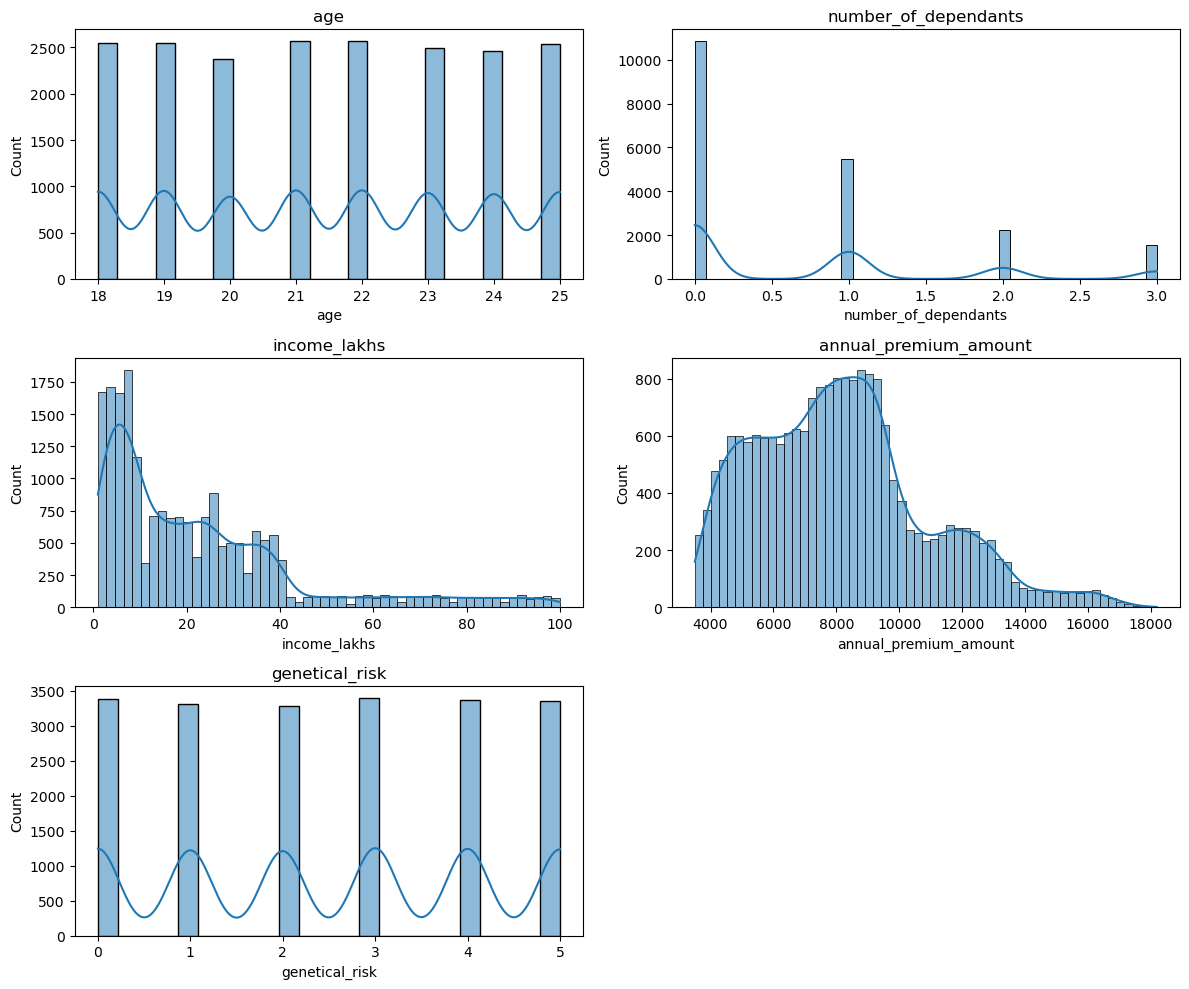

In [238]:


fig, axes = plt.subplots(3, 2, figsize=(12, 10))  # Create a 2x2 subplot grid
axes = axes.flatten()  # Flatten to make indexing easier

for i, col in enumerate(numeric_columns):
    sns.histplot(df2[col], kde=True, ax=axes[i])  # Assign each plot to a subplot
    axes[i].set_title(col)  # Add column name as title
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Delete empty subplots
    
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

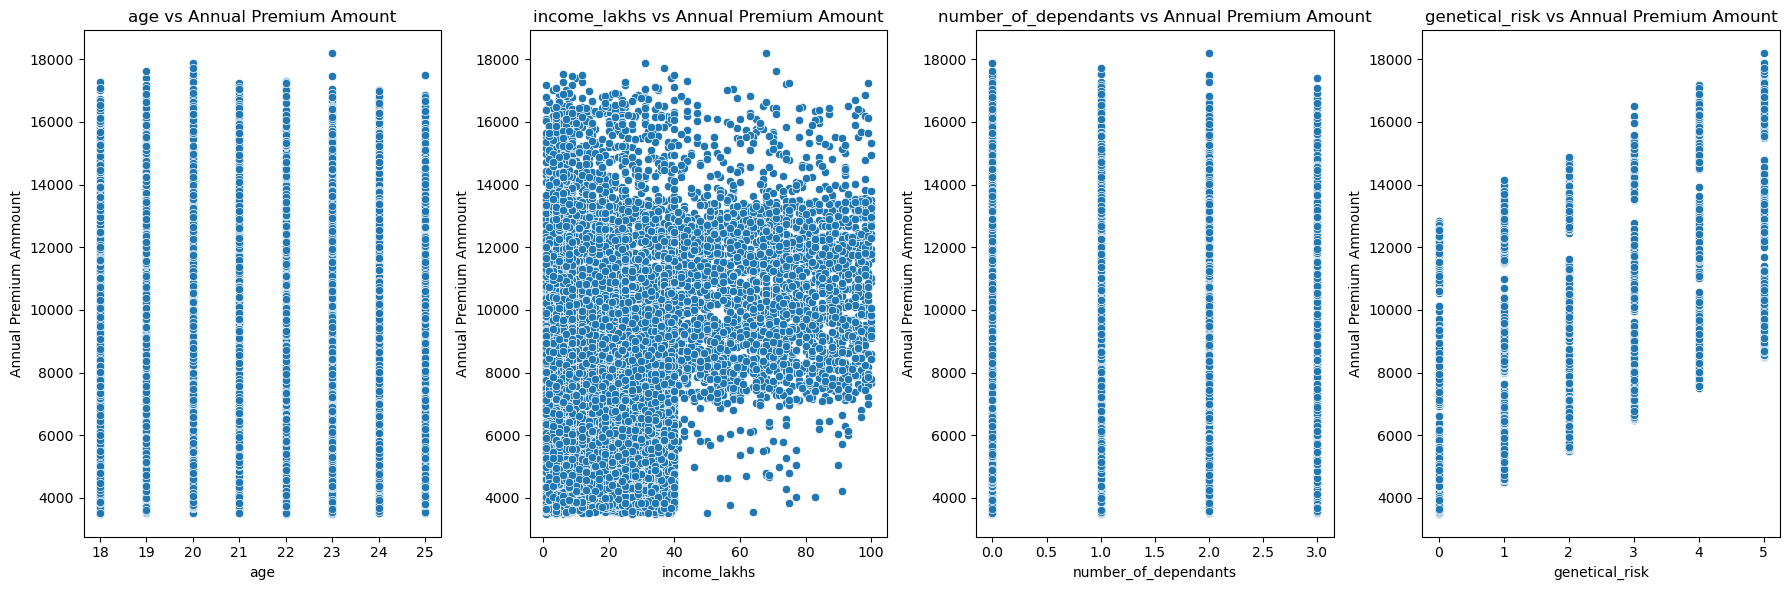

In [239]:
numeric_features = ['age' , 'income_lakhs' , 'number_of_dependants' , 'genetical_risk']

fig , axes = plt.subplots(1 , len(numeric_features) , figsize = (18,6))
axes = axes.flatten()

for i , column in enumerate(numeric_features):
    sns.scatterplot(x = df2[column] , y = df2["annual_premium_amount"] , ax= axes[i])
    axes[i].set_title(f'{column} vs Annual Premium Amount')   
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Annual Premium Ammount")
    
plt.tight_layout()
plt.show()                

In [240]:
categorical_cols = df.select_dtypes(['object' , 'category']).columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [241]:
for col in categorical_cols:
    print(col , ":" , df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [242]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking' : 'No Smoking'
    
} , inplace = True)
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [243]:
pct_count = df2['gender'].value_counts(normalize = True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

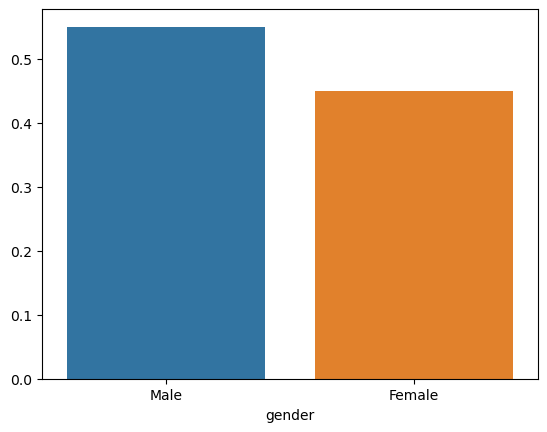

In [244]:
sns.barplot(x = pct_count.index , y = pct_count.values)

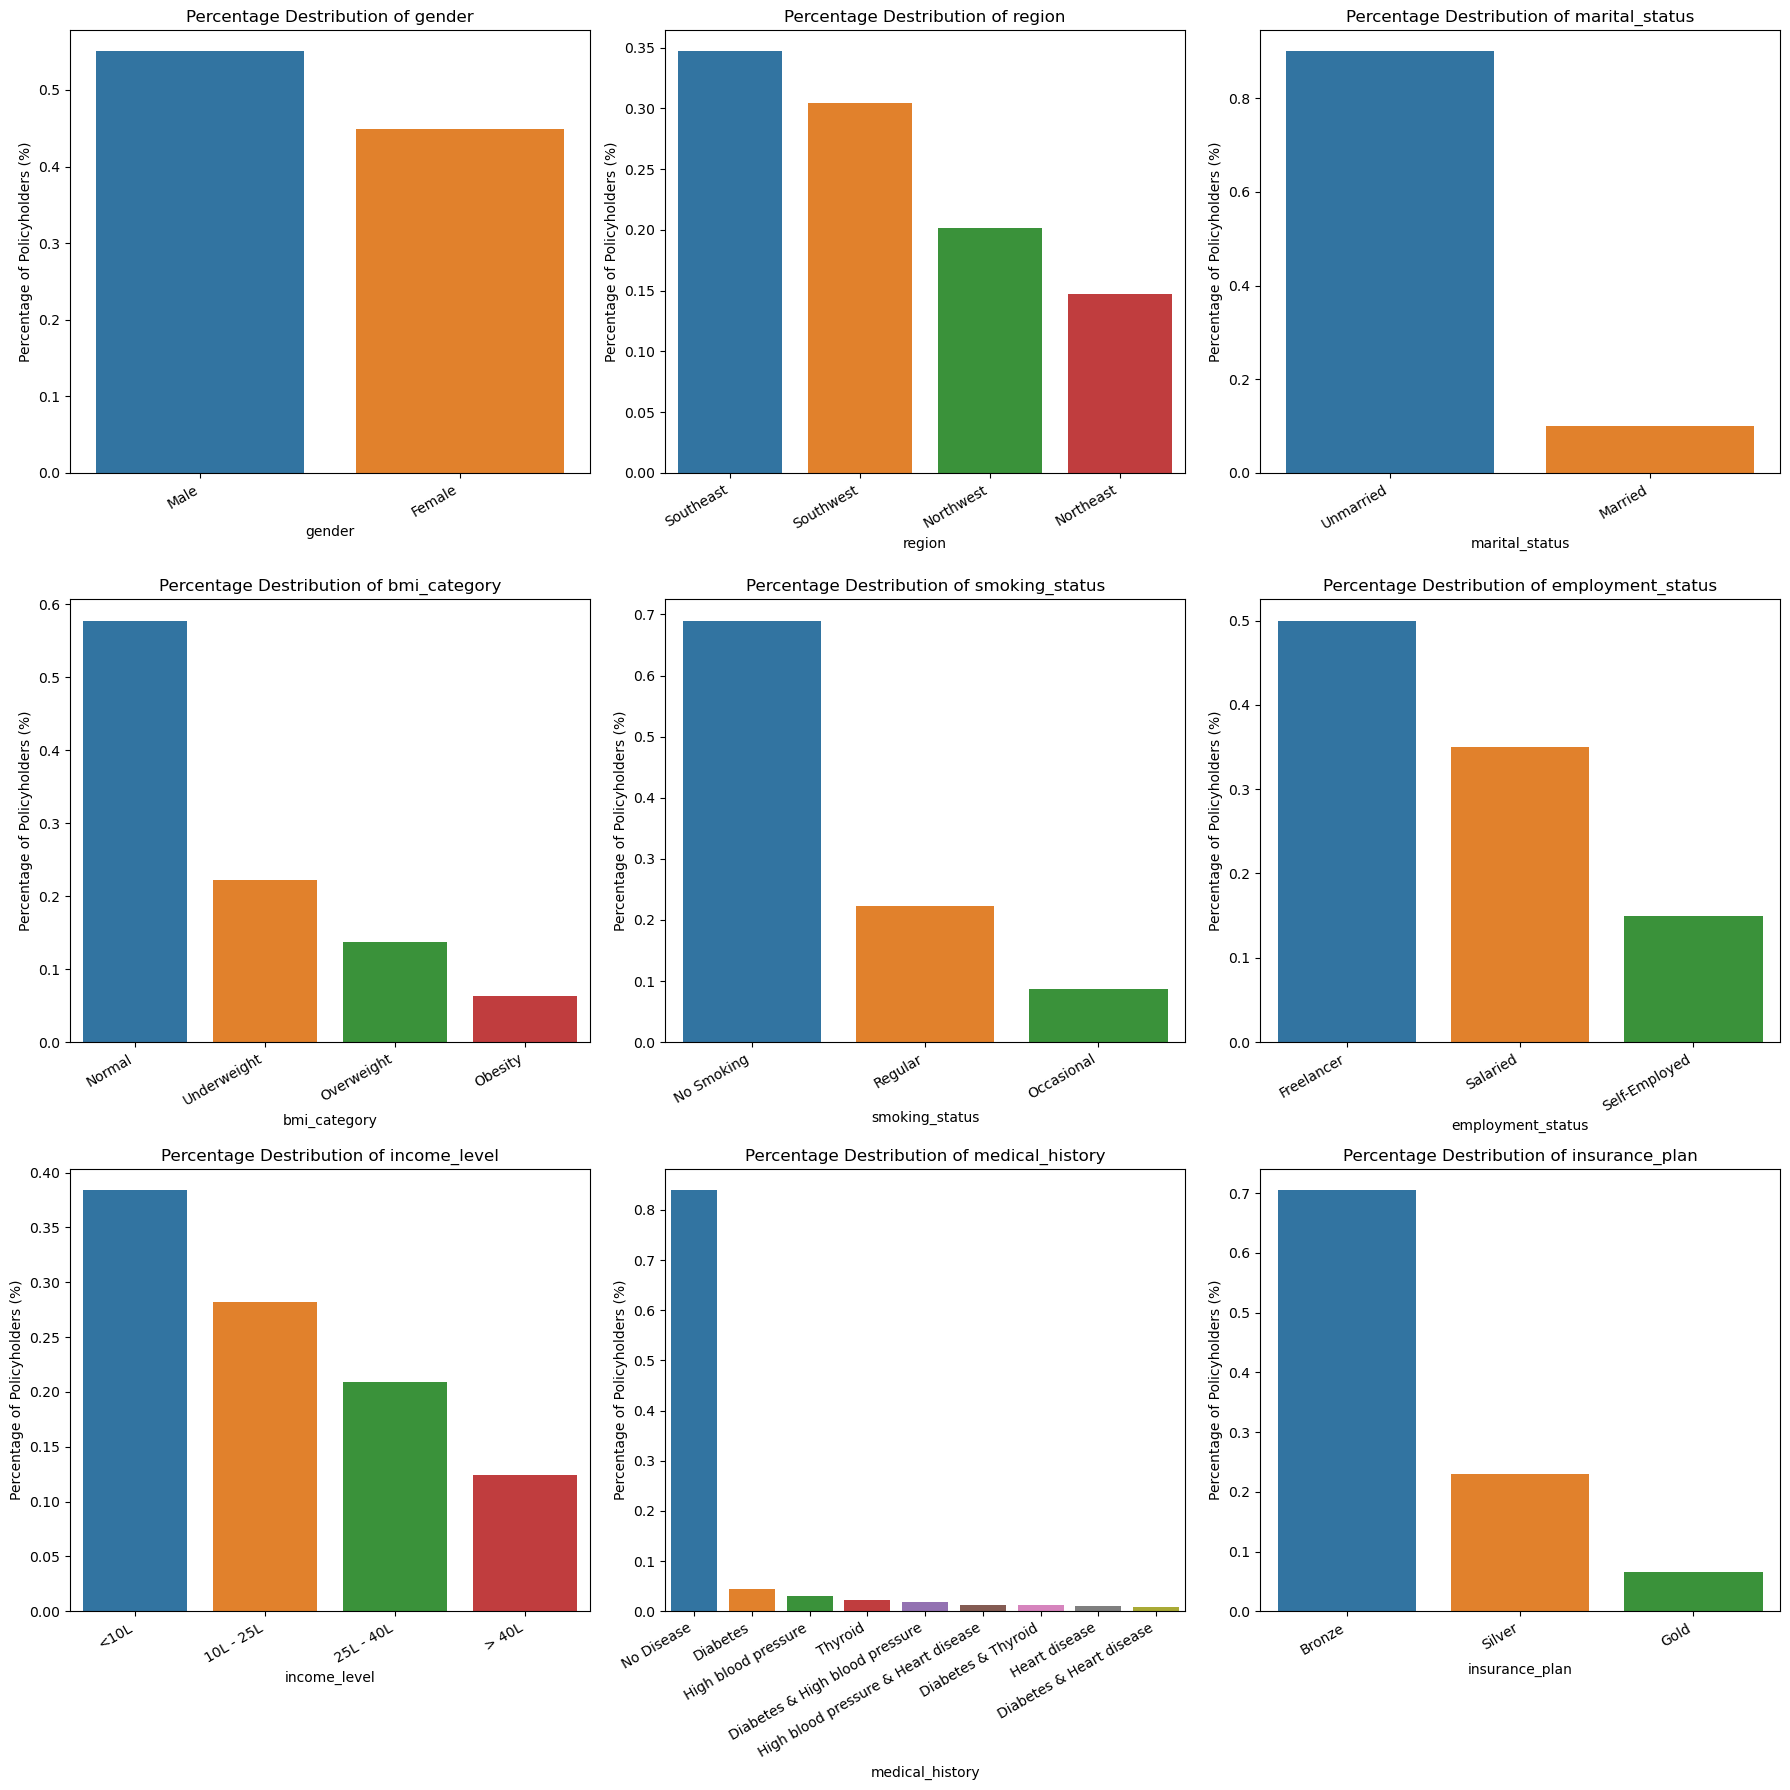

In [245]:
fig , axes = plt.subplots(3,3 , figsize =(18,18))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    pct_count = df2[col].value_counts(normalize = True)
    sns.barplot(x = pct_count.index , y = pct_count.values , ax = axes[i])
    axes[i].set_title(f'Percentage Destribution of {col}')
    axes[i].set_ylabel('Percentage of Policyholders (%)')
    axes[i].set_xlabel(col)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30, ha="right", fontsize=10)
plt.tight_layout()
plt.show()
    
    

In [246]:
crosstab = pd.crosstab(df2['income_level'] , df2['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,115,366,2023


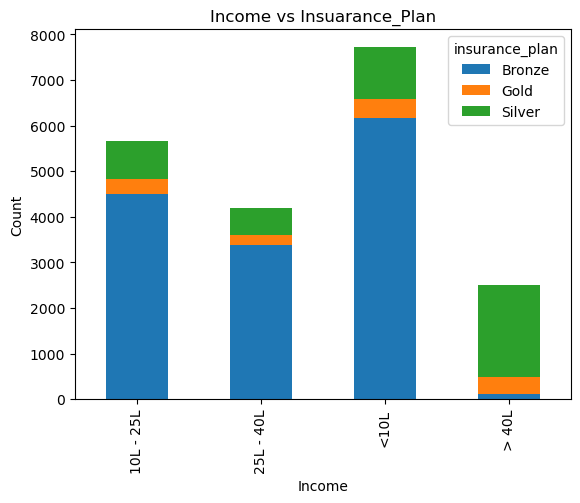

In [247]:
crosstab.plot(kind = 'bar' , stacked = True)
plt.title("Income vs Insuarance_Plan")
plt.ylabel("Count")
plt.xlabel("Income")
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

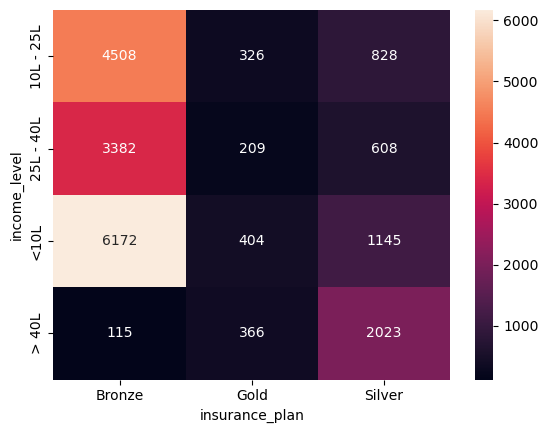

In [248]:
sns.heatmap(crosstab , annot =True , fmt = 'd')

## 2). Feature Engineering

In [249]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3


In [250]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [251]:
risk_scores = {
    "diabetes" : 6 , 
    "heart disease":8,
    "high blood pressure" : 6,
    "thyroid" : 5 , 
    "no disease" : 0,
    "none":0
}

df2[['disease1' ,'disease2']] = df2['medical_history'].str.split(" & " , expand = True).apply(lambda x: x.str.lower())
# (split) devide column value by & and (expand) add to two columns
df2.head(2)



,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,None


In [252]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

min_score = df2['total_risk_score'].min()
max_score = df2['total_risk_score'].max()
                
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000


In [253]:
df2.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [254]:
df2["insurance_plan"] = df["insurance_plan"].map({'Bronze' : 1 , 'Silver' : 2 , 'Gold' : 3})
df2["insurance_plan"].unique()

array([2, 1, 3], dtype=int64)

In [255]:
df2["income_level"] = df["income_level"].map({'<10L' : 1 , '10L - 25L':2 , '25L - 40L':3 , '> 40L':4})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,2,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,1,no disease,none,0,0.000000


In [256]:
nominal_cols = ['gender','region','marital_status','bmi_category' , 'smoking_status','employment_status']

df3 = pd.get_dummies(df2 , columns = nominal_cols , drop_first=True , dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,2,no disease,none,...,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,No Disease,1,5712,1,no disease,none,...,1,0,1,0,1,0,0,0,0,0


In [257]:
df3.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'medical_history', 'insurance_plan', 'annual_premium_amount',
       'genetical_risk', 'disease1', 'disease2', 'total_risk_score',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [258]:
df4 = df3.drop(['medical_history' , 'disease1','disease2','total_risk_score'],axis = 1)
#df4.head()



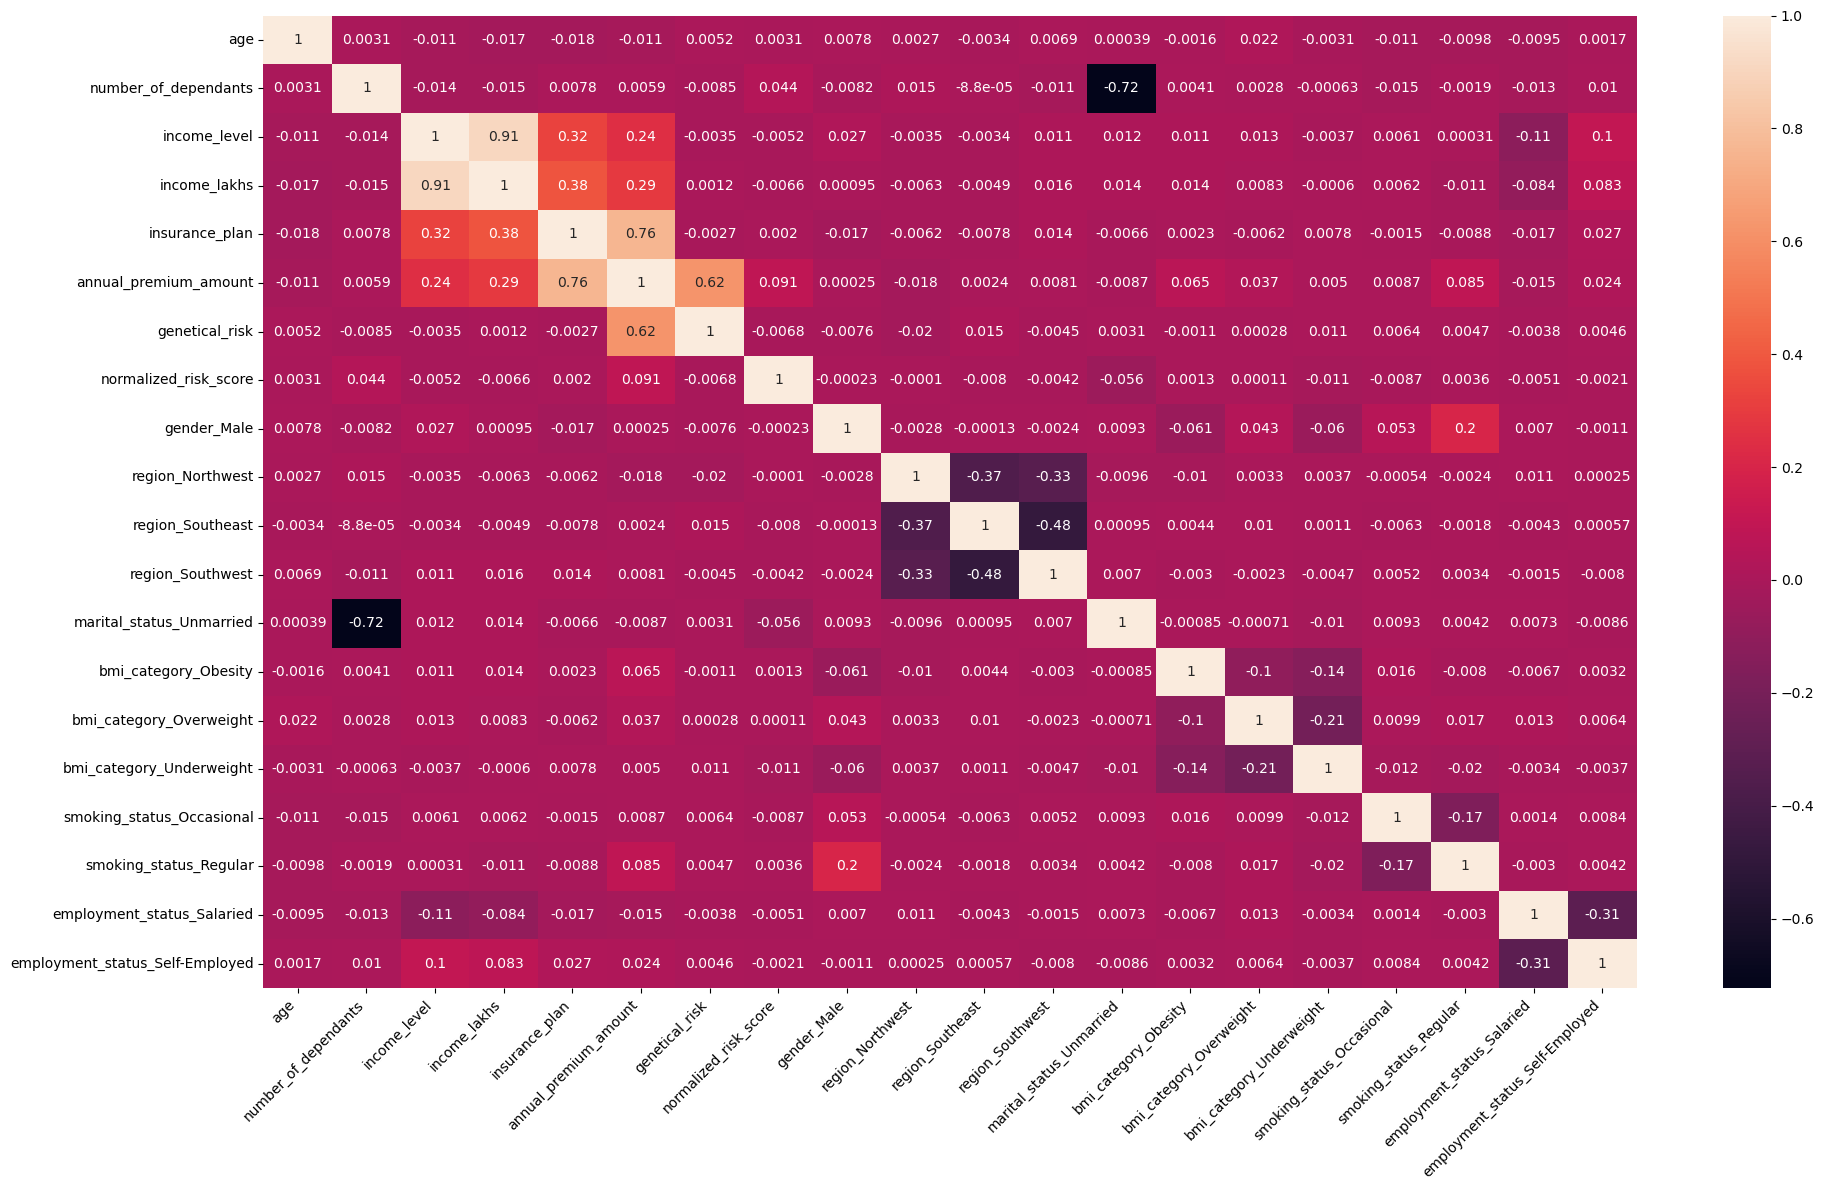

In [259]:
cm = df4.corr()      # correlation matrix

plt.figure(figsize =(20,12))
sns.heatmap(cm , annot = True)
plt.xticks(rotation =45 , ha ='right')
plt.yticks(rotation = 0 )
plt.tight_layout()
plt.show()

In [260]:
X = df4.drop('annual_premium_amount',axis = 1)
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan','genetical_risk']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.500777,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.342037,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.800000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [261]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values , i) for i in range(data.shape[1])]
    return vif_df


In [262]:
calculate_vif(X)

,column,VIF
0,age,3.154599
1,number_of_dependants,1.930428
2,income_level,11.928708
3,income_lakhs,11.876413
4,insurance_plan,1.592966
5,genetical_risk,2.981159
6,normalized_risk_score,1.154501
7,gender_Male,2.311831
8,region_Northwest,2.154355
9,region_Southeast,2.990493


In [263]:
calculate_vif(X.drop('income_level',axis = 1))  # two column have vif greater thn 10 , firstly remove highest vif and recheck




,column,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,normalized_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


In [264]:
X_reduced = X.drop('income_level',axis = 1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.4,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.2,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


## 3). Model Training

In [265]:
X_train ,X_test , y_train ,y_test = train_test_split(X_reduced , y ,test_size = 0.3 , random_state = 10 )

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test :", y_test.shape)

X_train : (14060, 18)
X_test : (6026, 18)
y_train : (14060,)
y_test : (6026,)


In [266]:
model_lr = LinearRegression()
model_lr.fit(X_train , y_train)

train_score = model_lr.score(X_train , y_train)
test_score = model_lr.score(X_test , y_test)

train_score , test_score

(0.988297900194864, 0.9887263253056615)

In [267]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test , y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE :", mse_lr , " RMSE : ",rmse_lr)

Linear Regression ==> MSE : 85732.34377930453  RMSE :  292.80086027760325


In [268]:
model_lr.intercept_

3978.8235284382627

In [269]:
model_lr.coef_

array([-7.22903185e+00,  1.95361819e+01, -1.26452776e+00,  7.00112526e+03,
        4.99698873e+03,  1.10914836e+03,  8.17798831e+00,  1.67735268e+00,
       -3.27532710e+00,  6.31709531e+00,  1.60689716e+01,  8.12844929e+02,
        4.00375598e+02,  1.07529819e+02,  2.05069661e+02,  6.10983280e+02,
        3.87836470e-02, -5.24201812e+00])

In [270]:
feature_importance = model_lr.coef_

coef_df = pd.DataFrame(feature_importance , index = X_test.columns , columns =['Coefficients'])
coef_df = coef_df.sort_values(by ='Coefficients',ascending = True)
coef_df


,Coefficients
age,-7.229032
employment_status_Self-Employed,-5.242018
region_Southeast,-3.275327
income_lakhs,-1.264528
employment_status_Salaried,0.038784
region_Northwest,1.677353
region_Southwest,6.317095
gender_Male,8.177988
marital_status_Unmarried,16.068972
number_of_dependants,19.536182


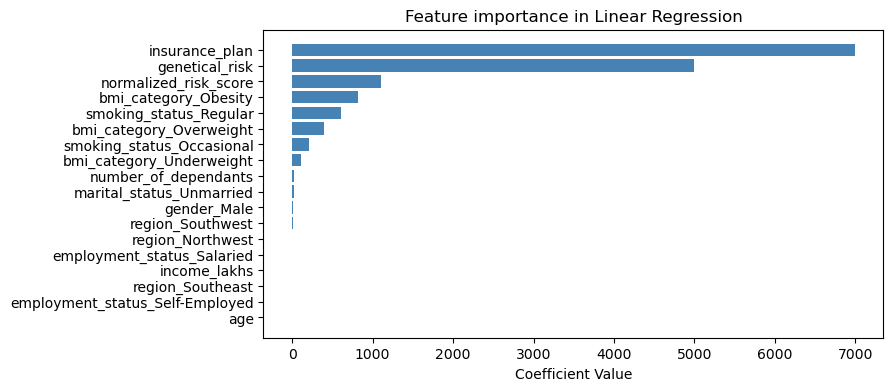

In [271]:
plt.figure(figsize = (8,4))
plt.barh(coef_df.index , coef_df["Coefficients"] , color = 'steelblue')
plt.xlabel('Coefficient Value')
plt.title("Feature importance in Linear Regression")
plt.show()

In [272]:
model_rg = Ridge()
model_rg.fit(X_train , y_train)

train_score = model_rg.score(X_train , y_train)
test_score = model_rg.score(X_test , y_test)

train_score , test_score


(0.9882972960153418, 0.9887275909694276)

In [273]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train , y_train)

train_score = model_xgb.score(X_train , y_train)
test_score = model_xgb.score(X_test , y_test)

train_score , test_score

(0.9925054809841402, 0.987729520869432)

In [274]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test , y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression ==> MSE :", mse_xgb , " RMSE : ",rmse_xgb)

XGBoost Regression ==> MSE : 93312.69206188193  RMSE :  305.4712622520847


In [275]:
best_model = model_lr

## 4). Error Analysis

In [276]:
# works with test data set

In [277]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals * 100 / y_test

results_df = pd.DataFrame({
    'actual' : y_test,
    'predicated' : y_pred,
    'diff' : residuals,
    'diff_pct' : residuals_pct
})

results_df.head()

,actual,predicated,diff,diff_pct
12774,6238,6121.456891,-116.543109,-1.868277
14758,9462,9601.797510,139.797510,1.477463
13205,5152,5611.056493,459.056493,8.910258
14278,6988,7423.486322,435.486322,6.231916
19351,4917,5112.056543,195.056543,3.966983


<Axes: xlabel='diff_pct', ylabel='Count'>

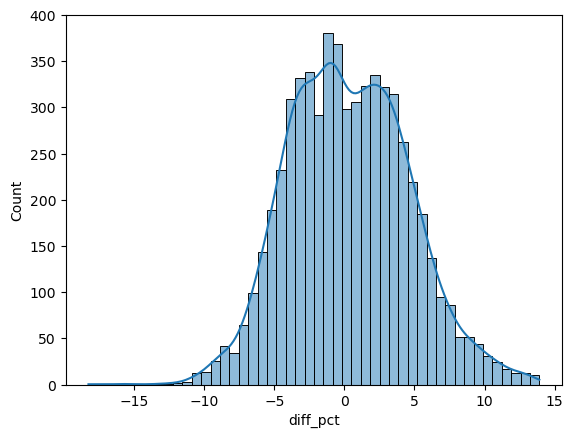

In [278]:
sns.histplot(results_df['diff_pct'] , kde = True)

In [279]:
extreme_error_threshold = 10        # our maximum error percentage is 10

extreme_results_df = results_df[np.abs(results_df.diff_pct) > extreme_error_threshold]
extreme_results_df

,actual,predicated,diff,diff_pct
12669,3985,4394.013230,409.013230,10.263820
2918,4517,5001.927338,484.927338,10.735606
17084,3562,3995.394401,433.394401,12.167165
7181,3630,4005.052340,375.052340,10.332020
12285,3532,3998.012625,466.012625,13.194015
...,...,...,...,...
1986,4633,5098.340369,465.340369,10.044040
8008,4902,5402.149195,500.149195,10.202962
9714,3624,4001.680590,377.680590,10.421650
7357,8608,7642.535233,-965.464767,-11.215901


In [280]:
results_df.shape    

(6026, 4)

In [281]:
extreme_errors_pct = extreme_results_df.shape[0] * 100 / results_df.shape[0]
extreme_errors_pct

2.140723531364089

In [282]:
# it means 2% of predictions , error is higher than 10% ( on test data)

In [283]:
extreme_results_df.index     # indexes of test records that have error graer than 10%


Index([12669,  2918, 17084,  7181, 12285, 13476, 15481,  2948,  4919, 15170,
       ...
       15166, 19580, 15664,  4204,  8692,  1986,  8008,  9714,  7357,  1534],
      dtype='int64', length=129)

In [284]:
extreme_errors_df = X_test.loc[extreme_results_df.index]  #  test records that have error grater than 10%
extreme_errors_df.head()


,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12669,0.857143,0.000000,0.000000,0.0,0.0,0.0,1,0,1,0,1,0,1,0,0,0,1,0
2918,0.285714,0.000000,0.151515,0.0,0.2,0.0,1,1,0,0,1,0,0,0,0,0,1,0
17084,1.000000,0.000000,0.353535,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0
7181,0.571429,0.000000,0.161616,0.0,0.0,0.0,1,0,0,1,1,0,0,0,0,0,0,0
12285,0.428571,0.333333,0.232323,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0


### Export the Model 

In [285]:
from joblib import dump

dump(best_model , "artifacts/model_young.joblib")

scaler_with_cols ={
    'scaler' :scaler,
    'cols_to_scale':cols_to_scale
}

dump(scaler_with_cols,"artifacts/scaler_young.joblib")



['artifacts/scaler_young.joblib']

In [286]:
scaler_with_cols ={
    'scaler' :scaler,
    'cols_to_scale':cols_to_scale
}
scaler_with_cols

{'scaler': MinMaxScaler(),
 'cols_to_scale': ['age',
  'number_of_dependants',
  'income_level',
  'income_lakhs',
  'insurance_plan',
  'genetical_risk']}

In [287]:
X_test.shape

(6026, 18)

In [288]:
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'genetical_risk', 'normalized_risk_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [292]:
import pandas as pd
import numpy as np
import xgboost
import sklearn
import joblib

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("xgboost:", xgboost.__version__)
print("scikit-learn:", sklearn.__version__)
print("joblib:", joblib.__version__)


pandas: 2.0.3
numpy: 1.24.3
xgboost: 2.1.3
scikit-learn: 1.3.1
joblib: 1.2.0
